In [10]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
from yahoofinancials import YahooFinancials

In [58]:
# Select stocks: Alibaba, Google,Netflix, Tesla, SP500, weekly,5 years
assets = ['BABA','AAPL', 'TSLA','NFLX','^GSPC',]
yahoo_financials = YahooFinancials(assets)

data = yahoo_financials.get_historical_price_data(start_date = '2015-01-01',
                                                  end_date = '2020-11-01',
                                                  time_interval = 'weekly')


### Data Preperation: 4 stocks, weekly return, log return, then make as portoflio

In [59]:
#data frame these stocks
stocks = pd.DataFrame({
      a: {x['formatted_date']: x['adjclose'] for x in data[a]['prices']} for a in assets
})
stocks.index.names = ['Date'] # note the data columns are index. cuz in the dictionary: key: value. keys are indexes. 
stocks.round(2)


,BABA,AAPL,TSLA,NFLX,^GSPC
Date,,,,,
2015-01-01,102.13,24.58,42.19,46.74,2025.90
2015-01-08,99.58,25.05,38.54,46.32,2011.27
2015-01-15,103.29,24.99,39.31,58.47,2032.12
2015-01-22,98.45,26.31,39.87,63.21,2002.16
2015-01-29,90.00,27.28,43.71,64.10,2041.51
...,...,...,...,...,...
2020-10-01,296.50,115.08,425.30,534.66,3419.44
2020-10-08,301.04,121.19,461.30,541.45,3488.67
2020-10-15,307.97,116.87,422.64,489.05,3435.56


In [61]:
# weekly return
stocks.pct_change(1).head()  #pct_change(periods)

,BABA,AAPL,TSLA,NFLX,^GSPC
2015-01-01,NaN,NaN,NaN,NaN,NaN
2015-01-08,-0.024968,0.019026,-0.086561,-0.009046,-0.007221
2015-01-15,0.037256,-0.002277,0.020136,0.262275,0.010367
2015-01-22,-0.046858,0.052579,0.014244,0.081069,-0.014743
2015-01-29,-0.085830,0.036857,0.096203,0.014126,0.019654


In [50]:
# mean weekly return
stock.pct_change(1).mean()

BABA     0.004820
AAPL     0.005756
TSLA     0.021934
NFLX     0.009439
^GSPC    0.001942
dtype: float64

In [51]:
# calculate log return. why use log return:  reduces the variation of the time series making it easier to fit the model in question.
log_return = np.log(stocks/stocks.shift(1))
log_return.head()

,BABA,AAPL,TSLA,NFLX,^GSPC
Date,,,,,
2015-01-01,NaN,NaN,NaN,NaN,NaN
2015-01-08,-0.025285,0.018847,-0.090538,-0.009088,-0.007248
2015-01-15,0.036579,-0.002280,0.019936,0.232916,0.010313
2015-01-22,-0.047992,0.051243,0.014144,0.077951,-0.014853
2015-01-29,-0.089739,0.036194,0.091852,0.014027,0.019463


In [52]:
log_return.mean()

BABA     0.003596
AAPL     0.004895
TSLA     0.007299
NFLX     0.007632
^GSPC    0.001575
dtype: float64

In [80]:
#select 4 stocks for portofolio
portfolio = log_return.iloc[:,0:4]
portfolio.head()

,BABA,AAPL,TSLA,NFLX
Date,,,,
2015-01-01,NaN,NaN,NaN,NaN
2015-01-08,-0.025285,0.018847,-0.090538,-0.009088
2015-01-15,0.036579,-0.002280,0.019936,0.232916
2015-01-22,-0.047992,0.051243,0.014144,0.077951
2015-01-29,-0.089739,0.036194,0.091852,0.014027


### Method 1: Random weights, select the best sharpe ratio to get the optimal weights

In [71]:
#stocks we selected
print(portfolio.columns)

#randdomly sign weights
weights = np.array(np.random.random(4))
print('Random weights:',weights)

Index(['BABA', 'AAPL', 'TSLA', 'NFLX'], dtype='object')
Random weights: [0.62274224 0.11433571 0.67698259 0.37966956]


In [73]:
#rebalance weights, range as 0-1
weights = weights/np.sum(weights)
print('Rebalanced weights: ',weights)

Rebalanced weights:  [0.34717722 0.06374187 0.37741609 0.21166482]


In [108]:
# expected return
exp_ret = np.sum((portfolio.mean()*weights))
print("Expected Return: ",exp_ret.round(6))


#expected volatility (std of expected return)
exp_vol = np.sqrt(np.dot(weights.T,np.dot(portfolio.cov(), weights))) # matrix multiplication
print('Expected Volatility: ', exp_vol.round(6))

# sharpe ratio
SR = exp_ret/exp_vol
print('Sharpe Ratio: ',SR.round(6))

Expected Return:  0.005931
Expected Volatility:  0.070609
Sharpe Ratio:  0.083992


In [209]:
# randomly try for 5000 times and select the best one 
num_times = 5000
all_weights = np.zeros((num_times,len(portfolio.columns)))
ret_arr = np.zeros(num_times)
vol_arr = np.zeros(num_times)
sharpe_arr = np.zeros(num_times)

for i in range(num_times):
    #weights
    weights = np.array(np.random.random(4))
    weights = weights/np.sum(weights) # scale 0-1
    
    #save weights 
    all_weights[i,:] = weights 
    
    #expected return
    ret_arr[i] = np.sum(portfolio.mean()*weights)
    
    #expected volatility
    vol_arr[i] = np.sqrt(np.dot(weights.T,np.dot(portfolio.cov(), weights)))  
    
      # Sharpe Ratio 
    sharpe_arr[i] = ret_arr[i]/vol_arr[i]

In [212]:
# which t gets the optimal sharp ratio
optimal_sr_num = sharpe_arr.argmax()
print("The number ",optimal_sr_num, " time gives the optimal sharpe ratio ")

# the optimal sharpe ratio
optimal_sr = sharpe_arr.max()
print("Optimal Sharpe Ratio:  ", optimal_sr)

#apply the optimal ratio number to get the optimal return & volatility
optimal_sr_ret = ret_arr[optimal_sr_num]
optimal_sr_vol = vol_arr[optimal_sr_num]
print("The optimal expected return is : ", optimal_sr_ret)
print("The optimal expected volatility is : ", optimal_sr_vol)

#show the optimal weights, which gives the best sharpe ratio
optimal_weights = all_weights[sharpe_arr.argmax(),:]
print("The weights for the optimal choice:  ", optimal_weights)


The number  709  time gives the optimal sharpe ratio 
Optimal Sharpe Ratio:   0.16503664535024531
The optimal expected return is :  0.005895202328271718
The optimal expected volatility is :  0.03572056567049553
The weights for the optimal choice:   [0.03659361 0.57936921 0.01042036 0.37361682]


In [213]:
# apply the weights, just to check out the result
portofolio_sr = np.sum(portfolio.mean()*optimal_weights)
portofolio_sr

0.005895202328271718

In [214]:
#which t gets the largest portfolio return
max_ret_num = ret_arr.argmax()
print("The number ",max_return_num, " time gives the largest portfolio return")

#max expected return, max volatility
max_ret = ret_arr.max()
max_vol = vol_arr.max()
print("Max expected Return:  ", ret_arr.max())
print("Max expected Volatility:  ", vol_arr.max())

# sharpe ratio to get max return? 
max_ret_sr = sharpe_arr[max_ret_num]
print("The sharpe ratio to get the max return is: ", max_ret_sr)

The number  1163  time gives the largest portfolio return
Max expected Return:   0.00740783557205072
Max expected Volatility:   0.14305362926461754
The sharpe ratio to get the max return is:  0.09201112570754645


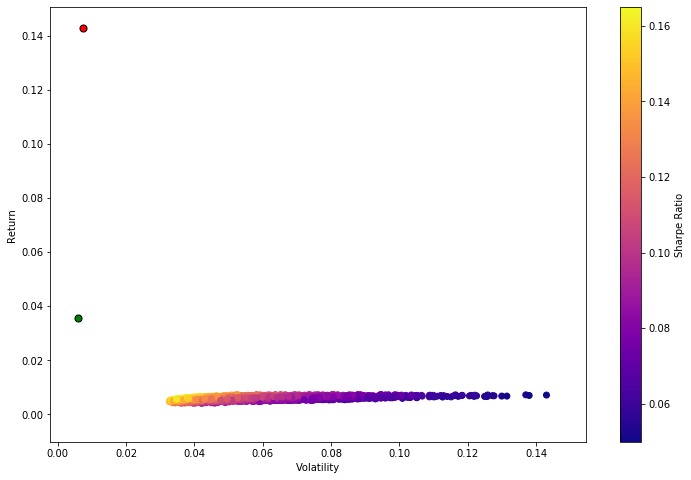

In [219]:
# plot the data
plt.figure(figsize=(12,8))
plt.scatter(vol_arr,ret_arr,c=sharpe_arr,cmap='plasma')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')


# locate the green dot for optimal_sr_ret,optimal_sr_vol,(where the optimal sharpe ratio happens)
plt.scatter(optimal_sr_ret, optimal_sr_vol, c='green', s=50, edgecolors='black')
plt.scatter(max_ret,max_vol,c = 'red', s=50,edgecolors='black')


In [185]:
# weeklt return comparison
result = pd.DataFrame([log_return.mean()],index=["Weekly Return"]) #single stock's weekly return
result['Portfolio'] = ret_arr.max()
result

,BABA,AAPL,TSLA,NFLX,^GSPC,Portfolio
Weekly Return,0.003596,0.004895,0.007299,0.007632,0.001575,0.007466


In [183]:
log_return.mean()

BABA     0.003596
AAPL     0.004895
TSLA     0.007299
NFLX     0.007632
^GSPC    0.001575
dtype: float64

In [188]:
print(max_sr_ret)
print(ret_arr.max())

0.006125046755118088
0.007466376118310759
